In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 1. Charger le dataset
dataset, info = tfds.load('malaria', as_supervised=True, with_info=True, shuffle_files=True)

In [3]:
# Informations sur le dataset
print("Description du dataset :")
print(info.description)
print("\nNombre total d'exemples :", info.splits['train'].num_examples)

Description du dataset :
The Malaria dataset contains a total of 27,558 cell images with equal instances
of parasitized and uninfected cells from the thin blood smear slide images of
segmented cells.

Nombre total d'exemples : 27558


In [4]:
# 2. Définir les fractions pour division en entraînement, validation et test
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Diviser les données en sous-ensembles
train_data = dataset['train'].take(int(info.splits['train'].num_examples * train_split))
val_data = dataset['train'].skip(int(info.splits['train'].num_examples * train_split)).take(int(info.splits['train'].num_examples * val_split))
test_data = dataset['train'].skip(int(info.splits['train'].num_examples * (train_split + val_split)))

# Vérification des tailles des datasets
print(f"Exemples d'entraînement : {len(list(train_data))}")
print(f"Exemples de validation : {len(list(val_data))}")
print(f"Exemples de test : {len(list(test_data))}")

Exemples d'entraînement : 22046
Exemples de validation : 2755
Exemples de test : 2756


In [5]:
# 3. Prétraitement des données
import tensorflow as tf

batch_size = 32
img_size = (128, 128)  # Taille des images cible

# Fonction de prétraitement des images (redimensionnement et normalisation)
def preprocess_image(image, label):
    """
    Prétraite une image :
    - Redimensionne l'image
    - Normalise les pixels entre 0 et 1
    """
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Encodage binaire des labels : 1 pour 'Parasitized', 0 pour 'Uninfected'
def encode_label(label):
    return tf.cast(label, tf.float32)

# Appliquer le prétraitement, l'augmentation et l'encodage binaire
def preprocess_and_encode(image, label):
    image, label = preprocess_image(image, label)
    label = encode_label(label)
    return image, label

# Optimisation du pipeline de données
AUTOTUNE = tf.data.AUTOTUNE

# Fonction pour préparer les données d'entraînement, validation et test
def prepare_data(dataset):
    # Appliquer prétraitement et éventuellement augmentation des données
    dataset = dataset.map(preprocess_and_encode, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

# Appliquer le prétraitement et l'augmentation des données d'entraînement
train_data = prepare_data(train_data)

# Prétraitement pour les jeux de validation et de test sans augmentation
val_data = prepare_data(val_data)
test_data = prepare_data(test_data)


Visualisation des données d'entraînement :


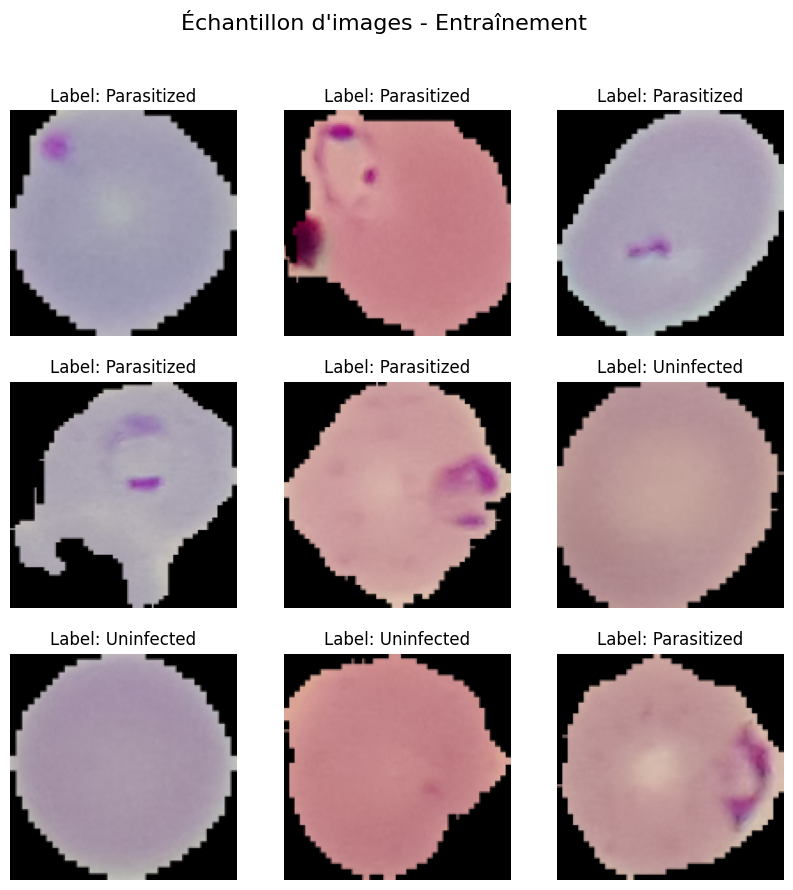

In [6]:
# 4. Visualiser un échantillon d'images et leurs labels
def visualize_sample(dataset, title, class_names=['Parasitized', 'Uninfected']):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Prenez un batch pour visualisation
        for i in range(9):  # Affichez les 9 premières images
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())  # Affichez la i-ème image du batch
            plt.title(f"Label: {class_names[int(labels[i].numpy())]}")  # Convertir le label en entier pour l'affichage
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

print("\nVisualisation des données d'entraînement :")
visualize_sample(train_data, "Échantillon d'images - Entraînement")


Répartition des classes dans chaque sous-dataset :


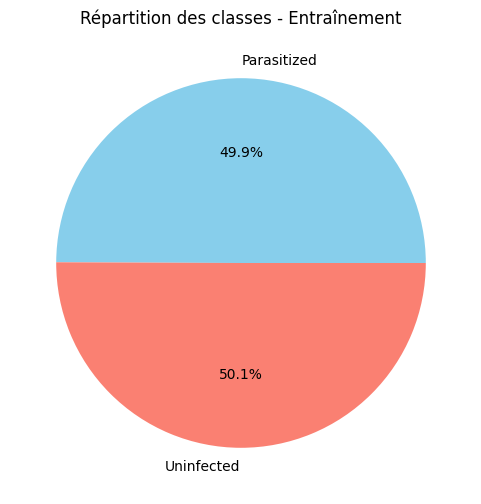

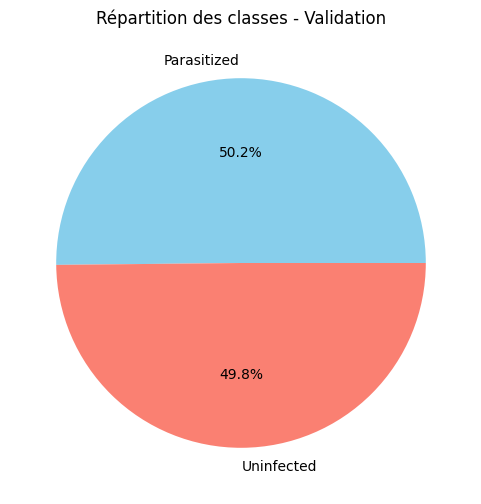

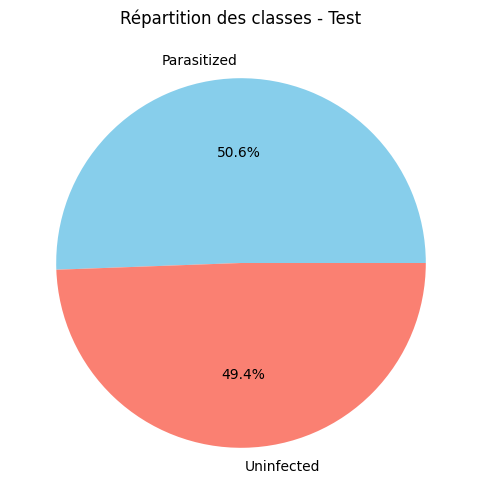

In [7]:
# 5. Répartition des classes
def plot_class_distribution(dataset, dataset_name, class_names=['Parasitized', 'Uninfected']):
    labels = np.concatenate([y.numpy() for _, y in dataset])
    unique, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(6, 6))
    plt.pie(
        counts,
        labels=[class_names[int(i)] for i in unique],
        autopct='%1.1f%%',
        colors=['skyblue', 'salmon']
    )
    plt.title(f"Répartition des classes - {dataset_name}")
    plt.show()

print("\nRépartition des classes dans chaque sous-dataset :")
plot_class_distribution(train_data, "Entraînement")
plot_class_distribution(val_data, "Validation")
plot_class_distribution(test_data, "Test")


In [9]:
from keras import Input
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1. Conception du modèle CNN
def create_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Bloc Convolutionnel 1
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloc Convolutionnel 2
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bloc Convolutionnel 3
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Couches entièrement connectées
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Régularisation Dropout
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Sortie binaire

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Initialiser le modèle
model = create_model()

# Afficher un résumé du modèle
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 2. Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
# 3. Configuration des Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Surveiller la perte sur les données de validation
        patience=3,  # Arrêter l'entraînement après 3 époques sans amélioration
        verbose=1,
        restore_best_weights=True  # Restaurer les poids du meilleur modèle
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  # Réduire le learning rate si la perte de validation stagne
        factor=0.2,  # Réduire de 80%
        patience=3,  # Après 3 époques sans amélioration
        verbose=1
    )
]

In [12]:
# 4. Entraînement du modèle
epochs = 20
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.7685 - loss: 0.4697 - val_accuracy: 0.9441 - val_loss: 0.1688 - learning_rate: 0.0010
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 82ms/step - accuracy: 0.9458 - loss: 0.1669 - val_accuracy: 0.9554 - val_loss: 0.1488 - learning_rate: 0.0010
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.9559 - loss: 0.1338 - val_accuracy: 0.9514 - val_loss: 0.1565 - learning_rate: 0.0010
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.9607 - loss: 0.1219 - val_accuracy: 0.9623 - val_loss: 0.1315 - learning_rate: 0.0010
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.9641 - loss: 0.1053 - val_accuracy: 0.9586 - val_loss: 0.1451 - learning_rate: 0.0010
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.9672 - loss: 0.0949 - val_accuracy: 0.9593 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.9706 - l

In [13]:
# 5. Évaluation des performances
print("\nÉvaluation sur les données de test :")
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Évaluation sur les données de test :
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9516 - loss: 0.1630
Test Loss: 0.1633
Test Accuracy: 0.9492


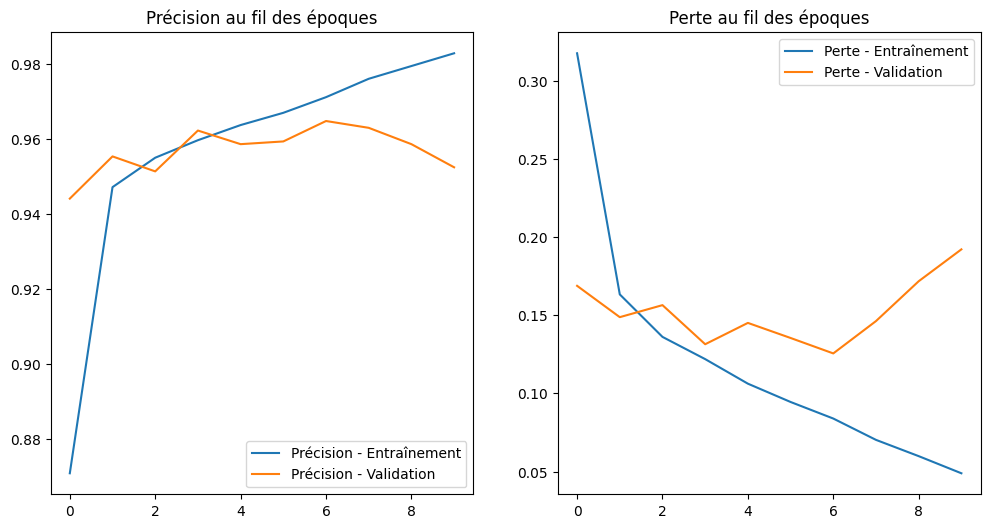

In [14]:
# 6. Affichage des courbes d'entraînement
def plot_training_history(history):
    """
    Affiche les courbes de précision et de perte au fil des époques.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Courbe de précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Précision - Entraînement')
    plt.plot(epochs_range, val_acc, label='Précision - Validation')
    plt.legend(loc='lower right')
    plt.title('Précision au fil des époques')

    # Courbe de perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perte - Entraînement')
    plt.plot(epochs_range, val_loss, label='Perte - Validation')
    plt.legend(loc='upper right')
    plt.title('Perte au fil des époques')

    plt.show()

# Affichage des courbes
plot_training_history(history)


In [15]:
# Sauveagarde du modèle
model.save('model/model_cnn.keras')  # Save in the new Keras format

In [19]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Définition du modèle avec Keras Tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Définition du modèle avec Keras Tuner
def build_model(hp):
    inputs = Input(shape=(128, 128, 3))

    # Première couche convolutionnelle
    x = layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    )(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Couches convolutionnelles supplémentaires
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        x = layers.Conv2D(
            filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        )(x)
        x = layers.MaxPooling2D((2, 2))(x)

    # Couches entièrement connectées
    x = layers.Flatten()(x)
    x = layers.Dense(
        units=hp.Int('units', min_value=64, max_value=512, step=64),
        activation='relu'
    )(x)

    # Dropout pour éviter le surapprentissage
    x = layers.Dropout(0.5)(x)

    # Sortie binaire
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compilation du modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [20]:
# 2. Recherche des meilleurs hyperparamètres avec Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='tuner_hps',
    project_name='malaria_model_tuning'
)

In [21]:
# 3. Callbacks pour l'optimisation
callbacks_best_model = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

In [24]:
# 4. Lancer la recherche
import warnings
# Suppress deprecated function warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tuner.search(train_data, validation_data=val_data, epochs=10, callbacks=callbacks_best_model)

Trial 24 Complete [00h 03m 39s]
val_accuracy: 0.8130671381950378

Best val_accuracy So Far: 0.9626134037971497
Total elapsed time: 02h 05m 51s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
32                |128               |filters_1
3                 |3                 |num_conv_layers
96                |32                |filters_2
64                |128               |units
0.0005494         |0.00012175        |learning_rate
32                |96                |filters_3
96                |96                |filters_4
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
1                 |2                 |tuner/round
0021              |0015              |tuner/trial_id

Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 80ms/step - accuracy: 0.9616 - loss: 0.1175 - val_accuracy: 0.9572 - val_loss: 0.1296 - learning_rate: 5.4940e-04
Epoch 6/10


KeyboardInterrupt: 

In [ ]:
# 5. Résultats des meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Meilleurs hyperparamètres : {best_hps.values}")

# 6. Créer et entraîner le modèle avec les meilleurs hyperparamètres
best_model = tuner.hypermodel.build(best_hps)
history_best_model = best_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

# 7. Évaluation du modèle sur les données de test
test_loss, test_accuracy = best_model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
# Affichage des courbes
plot_training_history(history_best_model)

In [ ]:
# Sauveagarde du modèle
best_model.save('model/best_model_cnn.keras')